## Testing the full graph

## Setup

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core langchain-tavily pyyaml

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "agent-storm"

In [2]:
# Reading the entire contents of a text file
def read_file_contents(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            content = file.read()
            return content
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        return None
    except PermissionError:
        print(f"Error: Permission denied to read the file '{filename}'.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

## Generate Personas

In [4]:
personas_filename = "../prompts/create_personas_instructions.txt"

create_personas_instructions = read_file_contents(personas_filename)
if create_personas_instructions is not None:
    print("Done reading file", personas_filename)

Done reading file ../prompts/create_personas_instructions.txt


In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import uuid
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

class Persona(BaseModel):
    name: str = Field(
        description="Name of the persona."
    )
    role: str = Field(
        description="Role of the persona in the context of the topic.",
    )
    description: str = Field(
        description="Description of the persona focus, concerns, and expertise.",
    )
    @property
    def to_string(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    personas: List[Persona] = Field(
        description="Comprehensive list of personas with their names, roles and descriptions.",
    )

class GeneratePersonasState(TypedDict):
    topic: str # Topic of discussion
    max_personas: int # Number of personas
    human_boss_feedback: str # Human feedback
    personas: List[Persona] # experienced personas


def create_personas(state: GeneratePersonasState):
    
    """ Create personas """
    
    topic=state['topic']
    max_personas=state['max_personas']
    human_boss_feedback=state.get('human_boss_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = create_personas_instructions.format(topic=topic,
                                                         human_boss_feedback=human_boss_feedback, 
                                                         max_personas=max_personas)

    # Generate question 
    personas = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the group of experts.")])
    

    return {"personas": personas.personas}


def human_feedback(state: GeneratePersonasState):
    """ No-op node that should be interrupted on """
    pass


In [6]:
def insert_topic_in_graph(topic, max_personas, thread, graph):
    # Run the graph until the first interruption
    for event in graph.stream({"topic":topic,"max_personas":max_personas,}, thread, stream_mode="values"):
        personas = event.get('personas', '')
        if personas:
            for persona in personas:
                print(f"Name: {persona.name}")
                print(f"Role: {persona.role}")
                print(f"Description: {persona.description}")
                print("-" * 50)  


def get_human_feedback_to_generate_personas(thread, graph):

    boss_feedback = input("Give your feedback, boss (Enter for ending feedback):").strip()
    if boss_feedback != "":
        personas = graph.get_state(thread).values.get('personas')
        personas_str = '\n'.join([persona.to_string for persona in personas])
        boss_feedback = boss_feedback + "\n\n" + personas_str
        
        graph.update_state(thread, {"human_boss_feedback": boss_feedback}, as_node="human_feedback")
        
        # Continue the graph execution
        for event in graph.stream(None, thread, stream_mode="updates"):
            # Review
            personas = event.get('personas', '')
            if personas:
                for persona in personas:
                    print(f"Name: {persona.name}")
                    print(f"Role: {persona.role}")
                    print(f"Description: {persona.description}")
                    print("-" * 50) 
    print("-" * 50) 


def finish_personas_creation(thread, graph):
    # Continue the graph execution to end
    graph.update_state(thread, {"human_boss_feedback": None}, as_node="human_feedback")
    
    graph.stream(None, thread, stream_mode="updates")
    
    final_state = graph.get_state(thread)
    personas = final_state.values.get('personas')
    print("Final state of Personas:")
    for persona in personas:
        print(f"Name: {persona.name}")
        print(f"Role: {persona.role}")
        print(f"Description: {persona.description}")
        print("-" * 50) 

## Persona Agent

In [7]:
filename = "../prompts/web_search_instructions.txt"

search_instructions = read_file_contents(filename)
if search_instructions is not None:
    print("Done reading file", filename)

filename = "../prompts/generate_opinion_instructions.txt"

opinion_instructions = read_file_contents(filename)
if opinion_instructions is not None:
    print("Done reading file", filename)

Done reading file ../prompts/web_search_instructions.txt
Done reading file ../prompts/generate_opinion_instructions.txt


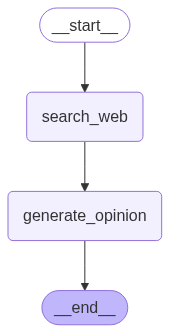

In [8]:
from langgraph.graph import MessagesState
from typing import  Annotated
import operator
from langchain_tavily import TavilySearch


tavily_search = TavilySearch(max_results=5, topic="general", include_raw_content=False)


class PersonaState(MessagesState):
    context: str # Source docs
    current_persona: Persona # Expert persona asking questions
    topic: str # Topic of discussion


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.", max_length=300)


def search_web(state: PersonaState):
    
    """ Retrieve docs from web search """

    topic = state["topic"]
    persona = state["current_persona"]
    messages = state["messages"]
    
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    system_message = search_instructions.format(topic=topic, persona=persona.to_string)
    search_query = structured_llm.invoke([SystemMessage(content=system_message)]+messages)
    
    # Search
    search_docs = tavily_search.invoke({"query": search_query.search_query})
              
     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs["results"]
        ]
    )

    return {"context": formatted_search_docs} 


def generate_opinion(state: PersonaState):
    
    """ Node to answer a question """

    # Get state
    persona = state["current_persona"]
    messages = state["messages"]
    context = state["context"]
    topic = state["topic"]

    # Generate an opinion
    system_message = opinion_instructions.format(topic=topic, persona=persona.to_string, context=context)
    opinion = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    # Append it to state
    return {"messages": [opinion]}


# Add nodes and edges 
persona_builder = StateGraph(PersonaState)
persona_builder.add_node("search_web", search_web)
persona_builder.add_node("generate_opinion", generate_opinion)

persona_builder.add_edge(START, "search_web")
persona_builder.add_edge("search_web", "generate_opinion")
persona_builder.add_edge("generate_opinion", END)

# Interview 
memory = MemorySaver()
persona_graph = persona_builder.compile(checkpointer=memory).with_config(run_name="Expert Persona")

# View
display(Image(persona_graph.get_graph().draw_mermaid_png()))


## Full Graph

In [9]:
filename = "../prompts/coordinator_instructions.txt"

coordinator_instructions = read_file_contents(filename)
if coordinator_instructions is not None:
    print("Done reading file", filename)

filename = "../prompts/summarize_meeting_instructions.txt"

summarize_meeting_instructions = read_file_contents(filename)
if summarize_meeting_instructions is not None:
    print("Done reading file", filename)

filename = "../prompts/compress_chat_instructions.txt"

compress_chat_instructions = read_file_contents(filename)
if compress_chat_instructions is not None:
    print("Done reading file", filename)

Done reading file ../prompts/coordinator_instructions.txt
Done reading file ../prompts/summarize_meeting_instructions.txt
Done reading file ../prompts/compress_chat_instructions.txt


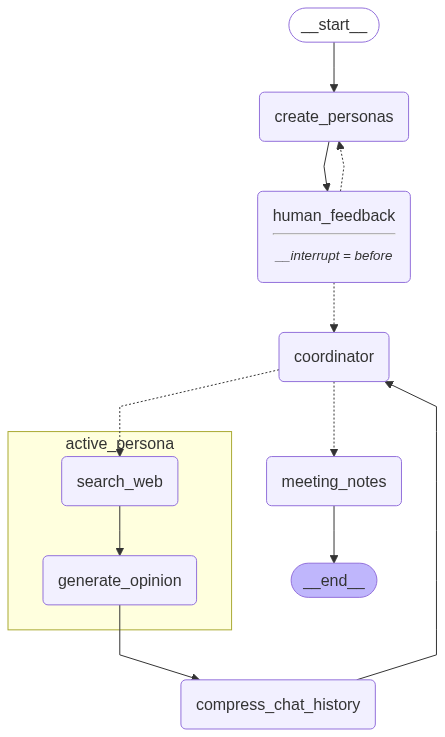

In [12]:
from langgraph.types import interrupt
from langgraph.types import Command
from typing_extensions import Literal
from langchain_core.messages import RemoveMessage
from langgraph.graph.message import REMOVE_ALL_MESSAGES


COMPRESSION_THRESHOLD = 6

class BrainStormState(MessagesState):
    topic: str
    max_personas: int 
    personas: List[Persona]
    current_persona: Persona 
    human_boss_feedback: str
    summary: str
    

def coordinate(state: BrainStormState) -> Command[Literal["meeting_notes", "active_persona"]]:
    response = interrupt("Do you have any comment?")
    human_input = response["human_input"]

    if human_input == "end":
        return Command(goto="meeting_notes", update={"messages": state["messages"], "topic": state["topic"]})

    else:    # decide next persona

        topic = state["topic"]
        personas = state["personas"]
        if human_input.strip() == "":
            messages = state["messages"]
        else:
            messages = state["messages"] + [HumanMessage(content=human_input)]
    
        personas_str = '\n'.join([persona.to_string for persona in personas])
        
        system_message = coordinator_instructions.format(topic=topic, personas=personas_str)
    
        structured_llm = llm.with_structured_output(Persona)
         
        persona = structured_llm.invoke([SystemMessage(content=system_message)]+messages)

        return Command(goto="active_persona", 
                       update={"current_persona": persona, "messages": messages, "topic": topic})


def compress_chat_history(state: BrainStormState):
    messages = state["messages"]
    
    if len(messages) <= COMPRESSION_THRESHOLD:
        return state

    messages_to_compress = messages[:-2]

    conversation_text = "\n\n".join([msg.content for msg in messages_to_compress])
    compression_prompt = compress_chat_instructions.format(conversation_text=conversation_text)
    
    
    summary_response = llm.invoke([HumanMessage(content=compression_prompt)])

    compressed_messages = [summary_response]
    for message in messages[-2:]:
        if isinstance(message, HumanMessage):
            compressed_messages.append(HumanMessage(content=message.content))
        else:
            compressed_messages.append(AIMessage(content=message.content))

    messages += compressed_messages
    
    return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}

    
def summarize_meeting(state: BrainStormState):
    topic = state["topic"]
    messages = state["messages"]

    summarization_prompt = summarize_meeting_instructions.format(topic=topic)

    summary = llm.invoke([HumanMessage(content=summarization_prompt)]+messages)

    return {"summary": summary}


def should_modify_personas(state: BrainStormState):
    # Check if human feedback
    human_boss_feedback=state.get('human_boss_feedback', None)
    if human_boss_feedback:
        return "create_personas"
    
    return "coordinator"



# create graph nodes and edges
builder = StateGraph(BrainStormState)
builder.add_node("create_personas", create_personas)
builder.add_node("human_feedback", human_feedback)
builder.add_node("coordinator", coordinate)
builder.add_node("active_persona", persona_graph)
builder.add_node("compress_chat_history", compress_chat_history)
builder.add_node("meeting_notes", summarize_meeting)

builder.add_edge(START, "create_personas")
builder.add_edge("create_personas", "human_feedback")
builder.add_conditional_edges("human_feedback", should_modify_personas, ["create_personas", "coordinator"])
builder.add_edge("active_persona", "compress_chat_history")
builder.add_edge("compress_chat_history", "coordinator")
builder.add_edge("meeting_notes", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### Testing the graph

In [13]:
thread_id = str(uuid.uuid4())
max_personas = 5
topic = "Who did really build the pyramids and how were they built?"
thread = {"configurable": {"thread_id": thread_id}}


insert_topic_in_graph(topic, max_personas, thread, graph)

get_human_feedback_to_generate_personas(thread, graph)

finish_personas_creation(thread, graph)

Name: Dr. Aisha El-Sayed
Role: Egyptologist and Field Archaeologist
Description: Focuses on funerary archaeology, inscriptions, and burial contexts. Brings expertise in interpreting tomb graffiti, workforce villages (e.g., Deir el-Medina, Heit el-Ghurab), and contemporary records (royal inscriptions, administrative papyri) to identify who actually built the pyramids and why. Concerned with primary evidence, dating, and integrating finds into the political and religious framework of Old Kingdom Egypt.
--------------------------------------------------
Name: Prof. Marcus Leclerc
Role: Structural Engineer and Ancient Construction Specialist
Description: Analyzes the engineering problems of quarrying, moving, and placing multi-ton blocks. Specializes in ramp theories, lever and sled mechanics, rope and sled friction, surveying and alignment techniques. Concerned with realistic load calculations, construction schedules, and reconciling proposed methods with the scale and precision of the mo

Give your feedback, boss (Enter for ending feedback): 


--------------------------------------------------
Final state of Personas:
Name: Dr. Aisha El-Sayed
Role: Egyptologist and Field Archaeologist
Description: Focuses on funerary archaeology, inscriptions, and burial contexts. Brings expertise in interpreting tomb graffiti, workforce villages (e.g., Deir el-Medina, Heit el-Ghurab), and contemporary records (royal inscriptions, administrative papyri) to identify who actually built the pyramids and why. Concerned with primary evidence, dating, and integrating finds into the political and religious framework of Old Kingdom Egypt.
--------------------------------------------------
Name: Prof. Marcus Leclerc
Role: Structural Engineer and Ancient Construction Specialist
Description: Analyzes the engineering problems of quarrying, moving, and placing multi-ton blocks. Specializes in ramp theories, lever and sled mechanics, rope and sled friction, surveying and alignment techniques. Concerned with realistic load calculations, construction schedu

In [15]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [], 'topic': 'Who did really build the pyramids and how were they built?', 'max_personas': 5, 'personas': [Persona(name='Dr. Aisha el-Masry', role='Egyptologist & Field Archaeologist', description='Focuses on the human evidence: worker villages, tomb inscriptions, payroll records, and funerary remains. Expertise in interpreting hieroglyphic records, cemetery archaeology, and social organization to explain who the builders were and how labor was organized.'), Persona(name='Prof. Thomas Sinclair', role='Structural Engineer and Construction Historian', description='Analyzes engineering solutions, load calculations, ramp hypotheses, and construction sequencing. Concerned with practical mechanics of lifting, aligning and placing huge blocks and with reconciling textual/archaeological evidence with feasible building techniques.'), Persona(name='Dr. Maya López', role='Experimental Archaeologist', description='Designs and runs hands-on reconstructions of ancie

### Initiate conversation

In [14]:
first_message = "What do you think?"

results = graph.invoke(Command(resume={"human_input": first_message}), thread, subgraphs=True)
results["messages"][-1].pretty_print()

================================== Ai Message ==================================

Dr. Aisha El-Sayed — Egyptologist and Field Archaeologist.

My view, based on inscriptions, worker burials and villages (Heit el‑Ghurab, Deir el‑Medina parallels), and administrative records (including the Wadi al‑Jarf papyri), is that the pyramids were built by organized Egyptian workforces: skilled masons, carpenters and engineers supplemented by seasonal laborers (a rotating corvée), not by chattel slaves. Graffiti with crew names, the cemeteries of workers treated with respect, and evidence of provisioning show these were state‑run projects that mobilized manpower, resources and logistics on an unprecedented scale.

Construction combined prodigious logistics (river transport by boats, canals and possibly purpose‑built harbors/dikes to bring stone to the plateau) with practical engineering: large sledges and rollers on wet sand, sophisticated stone dressing, and a mix of ramp and levering strategies. T

In [15]:
next_message = "But some people say it's aliens who built the pyramids because ancient technology cannot achieve this task."

results = graph.invoke(Command(resume={"human_input": next_message}), thread, subgraphs=True)
results["messages"][-1].pretty_print()

================================== Ai Message ==================================

Dr. Rafael Ortiz — Science Communicator and Mythbusting Specialist.

Short answer: no credible evidence that aliens built the pyramids, and the archaeological, textual and engineering records show how Old Kingdom Egyptians could and did build them. We have direct documentary and material traces of human organization and practice: the Wadi al‑Jarf papyri record shipments and labor related to stone transport, workmen’s graffiti on blocks name crews, the Heit el‑Ghurab settlement and worker cemeteries show large, provisioned labor forces, and quarry marks and ramps/sledge remains connect the quarries to the monuments.

On the engineering side, experimental archaeology and physics provide plausible, tested methods: heavy blocks moved on sledges over prepared tracks (wetting the sand drastically cuts friction), dolerite pounders and copper tools plus abrasive sand were used to dress stone, and a combination of

In [16]:
next_message = "But how could ancient Egyptians build something with that precision and carry all these huge rocks with no technology?."

results = graph.invoke(Command(resume={"human_input": next_message}), thread, subgraphs=True)
results["messages"][-1].pretty_print()

================================== Ai Message ==================================

Prof. Marcus Leclerc — Structural Engineer & Ancient Construction Specialist.

They did not need “modern” machines to achieve precision and lift heavy blocks — they had effective, repeatable low‑tech engineering. Surveyors used stars, merkhet‑like sighting rods, gnomons and plumb‑lines to set true north and cardinal lines; water in trenches or lined channels gave an accurate horizontal datum (water finds its own level) that could be transferred across the site to sub‑centimetre tolerances. Standardized cubit rods, templates, constant checking (trial fitting, rubbing finished casings together with abrasives) and highly skilled stonemasons produced the alignment, level and tight joints you see.

Moving the blocks relied on simple physics and organization. Core limestone was cut with copper tools and dolerite pounders, then floated on barges and boats along canals and the Nile to the plateau. On land, large 

In [17]:
next_message = "could this be the work of another extinct civilization that had more advanced technology that is lost today?."

results = graph.invoke(Command(resume={"human_input": next_message}), thread, subgraphs=True)
results["messages"][-1].pretty_print()

================================== Ai Message ==================================

Dr. Rafael Ortiz — Science Communicator and Mythbusting Specialist.

Short answer: no — there is no credible evidence that an extinct, more advanced civilization built the pyramids. The archaeological, textual and engineering records tie the monuments directly to Old Kingdom Egypt: quarry marks and tool marks, boat pits and Nile‑borne logistics (Wadi al‑Jarf/Merer papyri), the worker town at Heit el‑Ghurab and its cemeteries, crew graffiti on blocks, and administrative records and provisioning accounts. Those are independent, testable traces of people, organization and techniques — exactly the kind of evidence you should expect if humans built the pyramids.

If someone proposes a lost advanced culture, they must supply equally concrete, positive evidence: uncontested non‑Egyptian artifacts with a distinct technological signature, stratigraphic layers and radiocarbon dates placing that culture before or du

### Check message compression

In [18]:
for msg in graph.get_state(thread).values["messages"]:
    msg.pretty_print()

================================== Ai Message ==================================

Conversation context: a user asked for opinions on how the pyramids were built. Three experts replied, arguing for human, state‑organized construction and rebutting “aliens did it.”

Key points from each speaker
- Dr. Aisha El‑Sayed (Egyptologist/field archaeologist)
  - Pyramids built by organized Egyptian workforces: skilled artisans plus seasonal rotating labor (not chattel slaves).
  - Evidence: worker graffiti naming crews, worker villages and cemeteries (Heit el‑Ghurab, Deir el‑Medina parallels), administrative records (Wadi al‑Jarf papyri), provisioning and state logistics.
  - Construction combined river transport, canals/harbors, sledges on wet sand, stone dressing, and mixed ramp/levering techniques; specifics vary by site and phase.
  - Offers to point to key papyri, graffiti and excavation reports.

- Dr. Rafael Ortiz (science communicator/mythbusting specialist)
  - No credible evidence for e

In [19]:
next_message = ""

results = graph.invoke(Command(resume={"human_input": next_message}), thread, subgraphs=True)
results["messages"][-1].pretty_print()

================================== Ai Message ==================================

Dr. Aisha El‑Sayed — Egyptologist and Field Archaeologist.

Short answer: no — the pyramids are demonstrably the work of Old Kingdom Egypt. Multiple independent, datable lines of evidence link construction to Khufu and his administration: the Wadi al‑Jarf (Merer) papyri recording shipments of Tura limestone to “Akhet‑Khufu,” worker graffiti naming crews and supervisors on blocks, the worker town and cemeteries at Heit el‑Ghurab, the Giza boat pits and harbors, quarry marks and tool traces, plus radiocarbon and ceramic sequences that all fit the late 3rd/early 4th millennium BCE. These are direct, testable traces of people, logistics and organization — exactly what you would expect for a large state building project.

If someone argues for an earlier, more advanced lost civilization, they must produce positive, unambiguous material evidence of that culture in secure archaeological context: objects or techn

### End conversation

In [20]:
next_message = "end"

graph.invoke(Command(resume={"human_input": next_message}), thread, subgraphs=True)
state = graph.get_state(thread, subgraphs=True)
print(state.values.get('summary').content)

Concise summary of the discussion

- Consensus: the pyramids were built by Old Kingdom Egyptians using state‑organized labor (skilled crews plus rotating seasonal workers), not by aliens or a lost more‑advanced civilization.

- Key, datable evidence tying the work to Egyptians:
  - Wadi al‑Jarf (Merer) papyri recording shipments of Tura limestone to “Akhet‑Khufu.”
  - Worker graffiti naming crews and supervisors on blocks.
  - Worker town/cemeteries at Heit el‑Ghurab and related administrative/ provisioning remains.
  - Giza boat pits, quarry marks, tool marks, and consistent ceramic/radiocarbon sequences.

- Practical, demonstrated construction methods:
  - Quarrying with copper tools and dolerite pounders plus abrasive sand.
  - River/harbor transport on boats/barges; sledges on prepared tracks with wet sand to reduce friction.
  - Raising techniques: external ramps for lower courses, internal/spiral/temporary ramps and levering for higher courses; use of ropes, capstans, levers and 